In [1]:
!pip2 install -U lxml cssselect wordcloud matplotlib scikit-learn nltk Pillow >/dev/null
!python -c "import nltk; nltk.download('punkt')"
# use git fork until this is merged: https://github.com/geekpradd/PyLyrics/pull/4
!pip2 install git+https://github.com/adrianliaw/PyLyrics.git

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Cloning https://github.com/adrianliaw/PyLyrics.git to /tmp/pip-QYzVZD-build
    100% |████████████████████████████████| 92kB 1.9MB/s 
  Running setup.py install for PyLyrics ... - done
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from PyLyrics import *
import json
import os
import hashlib

# file cache
cache_dir = "./cache"

if not os.path.isdir(cache_dir):
    os.mkdirs(cache_dir)

def cacheFile(key):
     return os.path.join(cache_dir, key) + ".json"

def getCache(key):
    fname = cacheFile(key)
    if os.path.exists(fname):
        return json.load(open(fname,'r'))
    else:
        return None

def setCache(key, data):
    with open(cacheFile(key), 'w') as f:
        f.write(json.dumps(data))

def getAllTrackLyrics(artist, album_filter_fn=None):
    data = dict()
    data[artist] = []
    
    try:
        albums = PyLyrics.getAlbums(singer=artist)
    except Exception as e:
        if "Unknown Artist Name given":
            print("ERROR: Artist not found: {0}".format(artist))
            return {}

    if album_filter_fn:
        albums = list(filter(album_filter_fn, albums))
    
    cache_key = artist.lower() + " - " + hashlib.md5(artist + " - " + ";".join([str(x) for x in albums])).hexdigest()
    cache = getCache(cache_key)
    if cache:
        print("INFO: Returning cache: {0}".format(cache_key))
        return cache
    
    for album in albums:
        print("INFO: Getting tracks from {0} album: {1}".format(artist,album))
        album_track_lyrics = []
        try:
            for track in PyLyrics.getTracks(album):
                try:
                    lyrics = track.getLyrics()
                    album_track_lyrics.append({"album": str(album),"track": str(track), "lyrics": str(lyrics)})
                except Exception as e:
                    if "Song or Singer does not exist or the API does not have Lyrics" in str(e):
                        print("WARN: No lyrics for {0} - {1}".format(str(album), track))
            if album_track_lyrics:
                data[artist].append(album_track_lyrics)
        except Exception as e:
            print("WARN: Error getting tracks for album: {0}".format(album))

    if data:
        # set cache if data was found
        setCache(cache_key, data)

    return data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk

def makeWordCloud(text):
    cleaned = nltk.word_tokenize(text.lower())
    wordlist = [x for x in cleaned if (len(x)>2 and x.isalpha())]
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black').generate(" ".join(wordlist))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Enter artist: Daft Punk


/usr/local/lib/python2.7/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /usr/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


INFO: Returning cache: daft punk - 752b79e30ced396166c04f6b51ca1124


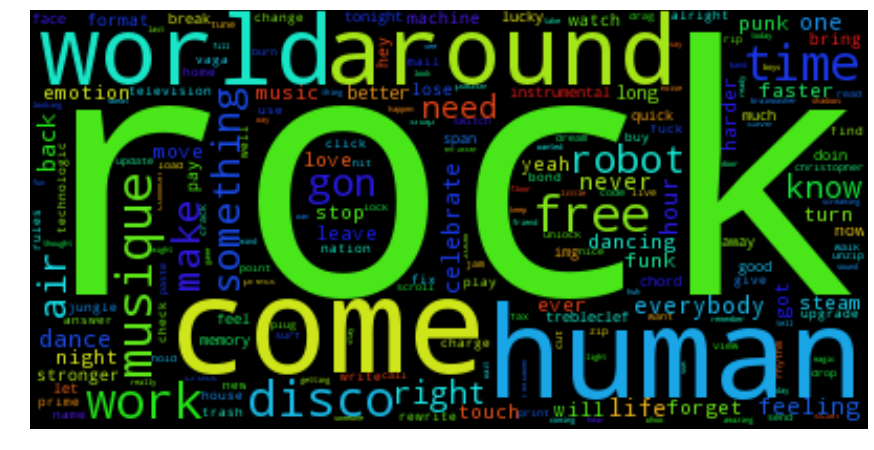

In [4]:
artist = raw_input("Enter artist: ")
albumFilter = None

# Fetch lyrics for specified albums
data = getAllTrackLyrics(artist, albumFilter)

if artist in data and data[artist]:
    # Join all lyrics together
    text = ' '.join([x["lyrics"] for album in data[artist] for x in album])
    
    makeWordCloud(text)